---
title: RealNVP - Real-valued Non-Volume Preserving
subtitle: Theory to Practice - A Tutorial on RealNVP representation.
date: 2025-10-15
bibliography:
  - references.bib
---

Real-Valued Non-Volume Preserving (RealNVP) is a normalizing flow model proposed by
[@dinh2016density]. It is a generalization of their previous NICE normalizing flow model proposed in
[@dinh2014nice]. RealNVP transformations are a set of powerful, stably invertible and learnable
transformations that result in an unsupervised learning algorithm that allows computation of exact
log-likelihood, exact and efficient sampling and exact and efficient inference of latent variables.
The neural architecture is invertible and therefore provides a way of representing only
non-self-intersecting geometry. We do this by using a Pre-Aux net with the RealNVP architecture. In
this tutorial, we walk through the theory behind the RealNVP representation and how to actually use
their `geodiff` implementation in practice.

In [1]:
# Basic Imports
import matplotlib.pyplot as plt
import torch

from geodiff.aux_nets import PreAuxNet
from geodiff.real_nvp import RealNVP
from geodiff.loss_functions.chamfer import ChamferLoss
from geodiff.template_architectures import ResMLP

from assets.utils import square, normalize_0_to_1


# Set the seed for reproducibility
torch.manual_seed(2)

## Theoretical Background
The RealNVP architecture as proposed in [@dinh2016density] is based on the idea of stacking simple
nonlinear invertible transformations. The architecture is built such that it is easy to compute the
inverse and the determinant of the Jacobian of the transformation. Computing the inverse and the
determinant of the Jacobian is useful for log-likelihood training of generative models (of say
images) but we do not require these properties and are only interested in the architecture being
guaranteed invertible. That is, as long as we are concerned we only need a guarantee on the
transformation represented by the network being invertible we will never actually want to invert it
or compute the Jacobian of the determinant. Therefore, we only focus on the `forward` pass of the
network and do not discuss the computations of the inverse or the determinant of the Jacobian.

The RealNVP architecture is composed of bijective transformations with triangular Jacobians that
serve as a building block for the entire transformation `f`. In particular, it uses an affine
coupling layer as the building block defined as follows:

**Affine coupling layer:** Let $x \in \mathbb{R}^{D}$ and $I_1, I_2$ be a partition of
$\llbracket 1, D \rrbracket$ with $d = |I_1|$ and $t, s$ be functions defined on $\mathbb{R}^{D}$.
We can define $y = (y_{I_1}, y_{I_2})$ where:
:::{math}
:label: affine_coupling_layer
y_{I_1} = x_{I_1} \\
y_{I_2} = x_{I_2} \odot exp(s(x_{I_1})) + t(x_{I_1})
:::
where, $s$ and $t$ stand for scale and translation and $\odot$ is the Hadamard product or the
element-wise product. If we choose
$I_1 = \llbracket 1, \, d \rrbracket, \ I_2 = \llbracket d+1, \, D \rrbracket$ then the Jacobian is
given by:
:::{math}
:label: RealNVP_Jacobian_single_layer
\frac{\partial y}{\partial x}
=
\begin{bmatrix}
I_d & 0\\
\displaystyle \frac{\partial y_{I_2}}{\partial x_{I_1}}
&
\operatorname{diag} \left( \exp [s(x_{I_1})] \right)
\end{bmatrix}
:::

The inverse mapping is obtained by:
:::{math}
:label: NICE_inverse
x_{I_1} = y_{I_1} \\
x_{I_2} = y_{I_2} - t(y_{I_1}) \odot \exp(-s(y_{I_1}))
:::

In contrast to NICE, affine coupling layers do not have has Jacobian determinant as is clear from
Eq. [](#RealNVP_Jacobian_single_layer), i.e. is not volume preserving. Therefore, the diagonal
scaling matrix used in NICE is not required with RealNVP.

## Implementation using `geodiff`
We now look at how `geodiff` allows us to easily use the RealNVP parameterization to represent
shapes.

The RealNVP class initializer and its expected arguments are shown below:
:::{literalinclude} ../src/geodiff/real_nvp.py
:start-at: __init__
:end-at: -> None
:::

To construct a RealNVP object, we need to supply:
- **Geometry Dimension** 2 for 2D and 3 for 3D.
- **Layer Count** the number of layers in the RealNVP architecture.
- **Translation Net** a torch network module to be used as the translation function.
- **Scaling Net** a torch network module to be used as the scaling function.
- **Pre-Aux Net** parameters such as layer count, hidden dimension, activation, normalization and
    output functions.
- **Boolean Flags** for using batch normalization and residual connections with the RealNVP layers.

### Fitting Shapes
We will use a square as our target geometry. We then use the `ChamferLoss` to compute the geometric
difference loss between the target shape and the shape represented by our RealNVP parameterization.
Since the implementation is written in PyTorch we can use the autograd capabilities to compute the
gradients of the loss w.r.t. the RealNVP network parameters and use an optimizer to modify our
geometry.

We start by obtaining points on our shapes and normalizing them appropriately such that
$x \in [0, 1]$. This is not needed for RealNVP but is used to offer a comparison with the classical
shape representation methods like Hicks-Henne and CST.

In [2]:
# Get points on a square (curve to fit)
num_pts = 1000
X_square = square(num_pts)

# Normalize x values to the range [0, 1] to compare with other representation methods
X_square = normalize_0_to_1(X_square)

We now create a `RealNVP` object by specifying the geometry dimension, layer count, coupling network
and Pre-Aux net parameters.

In [3]:
# Create a RealNVP object
# First create the Pre-Aux, translation and scaling networks to pass to the RealNVP initializer
preaux_net = PreAuxNet(geometry_dim = 2, layer_count = 2, hidden_dim = 20)
translation_net = ResMLP(input_dim = 1, output_dim = 1, layer_count = 2, hidden_dim = 20)
scale_net = ResMLP(input_dim = 1, output_dim = 1, layer_count = 2, hidden_dim = 20,
                   act_f = torch.nn.Tanh)
real_nvp = RealNVP(
    geometry_dim = 2,
    layer_count = 4,
    preaux_net = preaux_net,
    translation_net = translation_net,
    scale_net = scale_net,
)

We use the `ChamferLoss` provided by `geodiff` to compute a geometric loss between the target shape
and the shape represented by the `RealNVP` object. PyTorch's autograd capabilities then allow us to
compute gradients of the loss w.r.t. the RealNVP network parameters and modify them to fit the
target shape.

In [4]:
# Train the RealNVP parameters to fit the square
loss_fn = ChamferLoss()

learning_rate = 0.001
epochs = 1000
print_cost_every = 200

Y_train = X_square

optimizer = torch.optim.Adam(real_nvp.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.99)

for epoch in range(epochs):
    Y_model = real_nvp(num_pts = num_pts)
    
    loss = loss_fn(Y_model, Y_train)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(loss.item())

    if epoch == 0 or (epoch + 1) % print_cost_every == 0:
        num_digits = len(str(epochs))
        print(f'Epoch: [{epoch + 1:{num_digits}}/{epochs}]. Loss: {loss.item():11.6f}')

Epoch: [   1/1000]. Loss:    0.377009
Epoch: [ 200/1000]. Loss:    0.002237
Epoch: [ 400/1000]. Loss:    0.000316
Epoch: [ 600/1000]. Loss:    0.000194
Epoch: [ 800/1000]. Loss:    0.000123
Epoch: [1000/1000]. Loss:    0.000116


We can now visualize the shape represented by our `RealNVP` object using its `visualize` method.

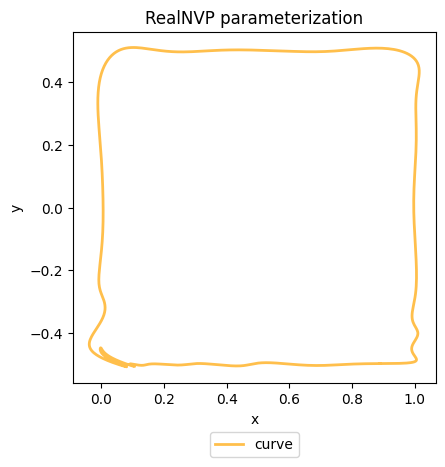

In [5]:
# Visualize the fitted RealNVP shape
fig, ax = real_nvp.visualize(num_pts = num_pts)
plt.tight_layout()
plt.show()